# 📘 Day 5 (07/11) — Valutazione Avanzata: PPL, Benchmark e Valutazione Umana

**Obiettivo pratico (4 ore di codice)**: Implementare metriche avanzate (perplessità), usare lm-eval-harness per benchmark, valutare su SQuAD, e condurre valutazione umana in classe.

---

## 🗺️ Roadmap della lezione (240 minuti di codice)

| **Sezione** | **Contenuto** | **Tempo stimato** |
|-------------|---------------|-------------------|
| 1 | Setup e teoria metriche tradizionali | 20' |
| 2 | Calcolo perplessità (PPL) | 50' |
| 3 | lm-eval-harness per benchmark | 60' |
| 4 | Valutazione su SQuAD (QA) | 60' |
| 5 | Valutazione umana in classe | 40' |
| 6 | Report finale e best practices | 10' |
| **TOTALE** | | **240'** |

---

## 📚 Leggi dopo (teoria fuori orario)

### Perplessità (Perplexity, PPL)
- **Definizione**: misura quanto il modello è "sorpreso" da una sequenza
- **Formula**: `PPL = exp(- (1/N) Σ log P(w_i | context))`
- **Interpretazione**: PPL bassa = modello prevede bene il testo
- **Range**: [1, +∞), tipicamente 10-100 per LLM moderni
- **Uso**: valutare qualità modello linguistico
- **Limiti**: non cattura utilità o allineamento

### Benchmark generali
- **lm-evaluation-harness**: framework per valutare LLM su task standard
- **Open LLM Leaderboard**: classifica pubblica su Hugging Face
- **HELM** (Stanford): benchmark olistico con 42 scenari
- **MMLU**: 57 task multi-disciplinari

### Benchmark task-specific
- **SQuAD**: Question Answering su Wikipedia
- **CNN/DailyMail**: Summarization di articoli
- **WMT**: Traduzione automatica
- **GLUE/SuperGLUE**: comprensione linguaggio naturale

### Valutazione umana
- **Criteri**: qualità, utilità, sicurezza, coerenza
- **Rubric**: scala Likert (1-5) per ogni criterio
- **Inter-annotator agreement**: Cohen's kappa, Fleiss' kappa
- **Costi**: $1-10 per valutazione
- **Best practices**: annotatori multipli, training, calibrazione

---

## 1️⃣ Setup e teoria metriche tradizionali (20 minuti)

In [1]:
# Installazione librerie
%pip install torch transformers datasets lm-eval matplotlib pandas numpy scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import librerie
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import os
import math
import warnings
warnings.filterwarnings('ignore')

# Seed
SEED = 42
set_seed(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Device: {device}")
print(f"✅ Seed: {SEED}")

✅ PyTorch: 2.8.0+cpu
✅ Device: cpu
✅ Seed: 42


In [3]:
# Creazione directory
os.makedirs('./results_day5', exist_ok=True)
print("✅ Directory create")

✅ Directory create


### 📖 Panoramica metriche tradizionali

| **Metrica** | **Cosa misura** | **Range** | **Uso principale** | **Vantaggi** | **Limiti** |
|-------------|-----------------|-----------|-------------------|--------------|------------|
| **Perplessità** | Sorpresa del modello | [1, +∞) | Language modeling | Veloce, interpretabile | Non cattura utilità |
| **BLEU** | Precision n-grammi | [0, 1] | Traduzione | Standard, veloce | Favorisce match esatti |
| **ROUGE** | Recall n-grammi | [0, 1] | Summarization | Complementare a BLEU | Ignora semantica |
| **Accuracy** | Predizioni corrette | [0, 1] | Classification | Semplice | Misleading con classi sbilanciate |
| **F1** | Media armonica P/R | [0, 1] | Classification | Bilancia precision/recall | Non adatto a multi-class |

### Quando usare quale metrica:
- **Language modeling**: Perplessità
- **Traduzione**: BLEU, METEOR
- **Summarization**: ROUGE, BERTScore
- **QA**: Exact Match (EM), F1
- **Classification**: Accuracy, F1, AUC-ROC
- **Generazione aperta**: Valutazione umana + metriche automatiche

---

## 2️⃣ Calcolo perplessità (PPL) (50 minuti)

La **perplessità** misura quanto il modello è "sorpreso" da una sequenza di token.

**Formula**:
```
PPL = exp(- (1/N) Σ log P(w_i | w_1, ..., w_{i-1}))
```

**Interpretazione**:
- PPL = 1: modello perfetto (predice sempre correttamente)
- PPL = 10: in media, modello è incerto tra 10 token
- PPL = 100: in media, modello è incerto tra 100 token

**Valori tipici**:
- GPT-2: PPL ~20-30 su test set
- GPT-3: PPL ~15-20
- Modelli piccoli: PPL ~50-100

In [4]:
# Carica modello
MODEL_NAME = 'distilgpt2'

print(f"⏳ Caricamento {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()
model.to(device)

print(f"✅ Modello caricato su {device}")

⏳ Caricamento distilgpt2...
✅ Modello caricato su cpu


In [5]:
# Funzione per calcolare perplessità
def calculate_perplexity(model, tokenizer, text: str) -> float:
    """
    Calcola perplessità di un testo.
    
    Args:
        model: modello causal LM
        tokenizer: tokenizer
        text: testo da valutare
    
    Returns:
        Perplessità (float)
    """
    # Tokenizza
    encodings = tokenizer(text, return_tensors='pt')
    input_ids = encodings.input_ids.to(device)
    
    # Calcola loss
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    
    # Perplessità = exp(loss)
    perplexity = torch.exp(loss).item()
    
    return perplexity

# Test
test_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Machine learning is a subset of artificial intelligence.",
    "asdfjkl qwerty zxcvbn"  # Testo nonsense
]

print("\n🧪 Test perplessità:\n")
for text in test_texts:
    ppl = calculate_perplexity(model, tokenizer, text)
    print(f"Text: {text}")
    print(f"PPL: {ppl:.2f}\n")


🧪 Test perplessità:



`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Text: The quick brown fox jumps over the lazy dog.
PPL: 569.89

Text: Machine learning is a subset of artificial intelligence.
PPL: 65.65

Text: asdfjkl qwerty zxcvbn
PPL: 497.89



In [6]:
# Calcola perplessità su dataset
# Usiamo WikiText-2 (dataset standard per language modeling)

print("⏳ Caricamento WikiText-2...")

dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

# Usa subset per velocità
texts = [ex['text'] for ex in dataset if len(ex['text']) > 50][:50]

print(f"✅ {len(texts)} testi caricati")

⏳ Caricamento WikiText-2...
✅ 50 testi caricati


In [7]:
# Calcola perplessità per ogni testo
print("\n⏳ Calcolo perplessità su WikiText-2... (questo richiederà qualche minuto)\n")

perplexities = []

for i, text in enumerate(texts):
    if i % 10 == 0:
        print(f"Progresso: {i}/{len(texts)}")
    
    try:
        ppl = calculate_perplexity(model, tokenizer, text)
        perplexities.append(ppl)
    except:
        # Skip testi problematici
        continue

mean_ppl = np.mean(perplexities)
median_ppl = np.median(perplexities)
std_ppl = np.std(perplexities)

print(f"\n✅ Perplessità calcolata su {len(perplexities)} testi")
print(f"\n📊 Statistiche:")
print(f"   Media: {mean_ppl:.2f}")
print(f"   Mediana: {median_ppl:.2f}")
print(f"   Std Dev: {std_ppl:.2f}")
print(f"   Min: {np.min(perplexities):.2f}")
print(f"   Max: {np.max(perplexities):.2f}")


⏳ Calcolo perplessità su WikiText-2... (questo richiederà qualche minuto)

Progresso: 0/50
Progresso: 10/50
Progresso: 20/50
Progresso: 30/50
Progresso: 40/50

✅ Perplessità calcolata su 50 testi

📊 Statistiche:
   Media: 109.89
   Mediana: 78.88
   Std Dev: 81.83
   Min: 37.04
   Max: 557.55



✅ Grafico salvato in ./results_day5/perplexity_distribution.png


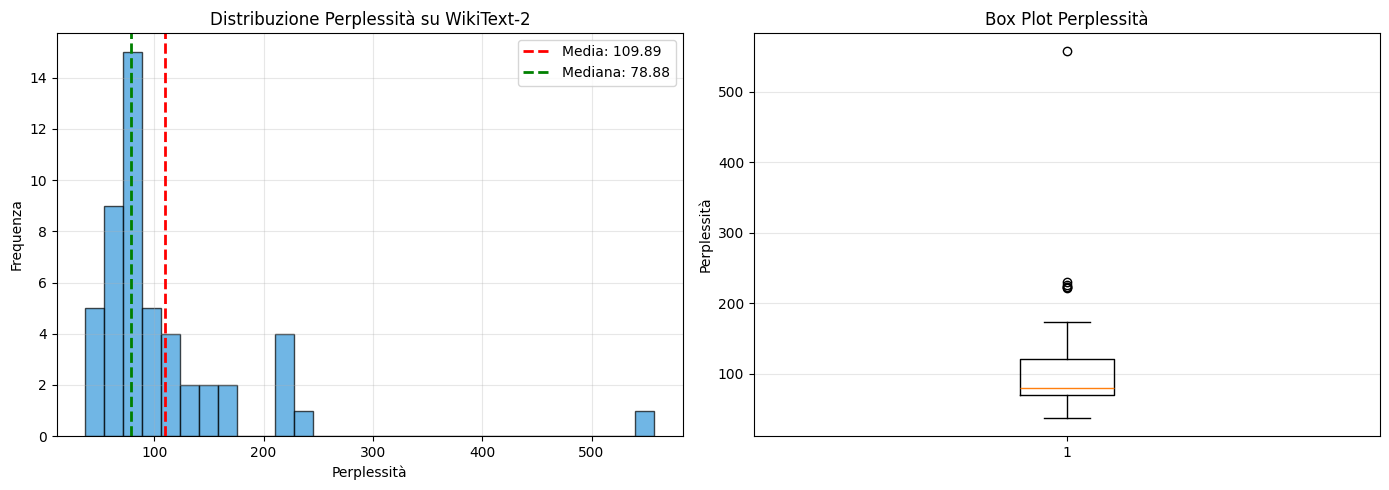

In [8]:
# Visualizza distribuzione perplessità
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram
axes[0].hist(perplexities, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(mean_ppl, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_ppl:.2f}')
axes[0].axvline(median_ppl, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_ppl:.2f}')
axes[0].set_xlabel('Perplessità')
axes[0].set_ylabel('Frequenza')
axes[0].set_title('Distribuzione Perplessità su WikiText-2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Box plot
axes[1].boxplot(perplexities, vert=True)
axes[1].set_ylabel('Perplessità')
axes[1].set_title('Box Plot Perplessità')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./results_day5/perplexity_distribution.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato in ./results_day5/perplexity_distribution.png")
plt.show()

### 💡 Interpretazione:

**Perplessità bassa** (< 30):
- Modello predice bene il testo
- Testo probabilmente in-distribution (simile a training data)

**Perplessità media** (30-100):
- Modello ha incertezza moderata
- Testo potrebbe essere out-of-distribution

**Perplessità alta** (> 100):
- Modello molto incerto
- Testo probabilmente molto diverso da training data
- Possibile testo nonsense o linguaggio tecnico

**Limiti**:
- Non misura utilità o allineamento
- Può essere bassa anche per testo inutile
- Dipende fortemente da training data

---

## 3️⃣ lm-eval-harness per benchmark (60 minuti)

**lm-evaluation-harness** è un framework di EleutherAI per valutare LLM su task standard.

**Task supportati**: 200+
- **MMLU**: 57 task multi-disciplinari
- **HellaSwag**: common sense reasoning
- **TruthfulQA**: truthfulness
- **GSM8K**: math reasoning
- **HumanEval**: code generation

**Output**: accuracy, perplexity, F1, etc.

In [9]:
# Installazione lm-eval
%pip install lm-eval -q

Note: you may need to restart the kernel to use updated packages.


In [15]:
import subprocess
import json
import os
import glob

print("⏳ Esecuzione lm-eval su task semplice (hellaswag)...")
print("   Nota: questo richiederà ~5-10 minuti\n")

# Imposta variabile ambiente per UTF-8 (Windows)
env = os.environ.copy()
env['PYTHONIOENCODING'] = 'utf-8'

# Esegui lm-eval
cmd = [
    'lm_eval',
    '--device', 'cpu', 
    '--model', 'hf',
    '--model_args', f'pretrained={MODEL_NAME}',
    '--tasks', 'hellaswag',
    '--limit', '10',
    '--output_path', './results_day5/lm_eval_results'
]

try:
    # Esegui con encoding UTF-8
    result = subprocess.run(
        cmd, 
        capture_output=True, 
        text=True,
        encoding='utf-8',  # Forza UTF-8
        errors='replace',  # Sostituisci caratteri non decodificabili
        timeout=900,
        env=env
    )
    
    # Stampa output (può contenere Unicode)
    if result.stdout:
        print(result.stdout)
    
    if result.returncode != 0:
        print(f"\n⚠️  lm-eval exit code: {result.returncode}")
        if result.stderr:
            print(f"stderr: {result.stderr[:500]}...")  # Primi 500 char
    
    # Leggi risultati da JSON
    # Cerca file JSON nella directory results_day5
    json_files = glob.glob('./results_day5/*.json')
    if json_files:
        json_path = json_files[0]  # Prendi il primo
        print(f"\n📊 Lettura risultati da: {json_path}")
    
    with open(json_path, 'r', encoding='utf-8') as f:
        results = json.load(f)
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            results = json.load(f)
        
        print("\n✅ Risultati lm-eval (hellaswag):\n")
        
        if 'results' in results:
            for task, metrics in results['results'].items():
                print(f"   Task: {task}")
                for metric, value in metrics.items():
                    if isinstance(value, (int, float)):
                        print(f"      {metric}: {value:.4f}")
                    else:
                        print(f"      {metric}: {value}")
        
        print(f"\n💡 Risultati completi salvati in: {json_path}")
        
    except FileNotFoundError:
        print(f"\n⚠️  File risultati non trovato: {json_path}")
        print("   lm-eval potrebbe non aver completato correttamente")
    except Exception as e:
        print(f"\n⚠️  Errore lettura JSON: {e}")

except subprocess.TimeoutExpired:
    print("\n⚠️ lm-eval timeout (>15 minuti)")
except FileNotFoundError:
    print("\n⚠️ lm_eval non installato")
    print("   Installa con: pip install lm-eval")
except Exception as e:
    print(f"\n⚠️ Errore: {e}")


⏳ Esecuzione lm-eval su task semplice (hellaswag)...
   Nota: questo richiederà ~5-10 minuti

hf (pretrained=distilgpt2), gen_kwargs: (None), limit: 10.0, num_fewshot: None, batch_size: 1
|  Tasks  |Version|Filter|n-shot| Metric |   |Value|   |Stderr|
|---------|------:|------|-----:|--------|---|----:|---|-----:|
|hellaswag|      1|none  |     0|acc     |↑  |  0.3|±  |0.1528|
|         |       |none  |     0|acc_norm|↑  |  0.4|±  |0.1633|



📊 Lettura risultati da: ./results_day5\lm_eval_results_2025-10-27T11-41-57.442338.json

✅ Risultati lm-eval (hellaswag):

   Task: hellaswag
      alias: hellaswag
      acc,none: 0.3000
      acc_stderr,none: 0.1528
      acc_norm,none: 0.4000
      acc_norm_stderr,none: 0.1633

💡 Risultati completi salvati in: ./results_day5\lm_eval_results_2025-10-27T11-41-57.442338.json


### 



💡 Interpretazione risultati lm-eval:

**HellaSwag** (common sense reasoning):
- **Accuracy**: % risposte corrette
- **Baseline random**: 25% (4 opzioni)
- **GPT-2 small**: ~30-35%
- **GPT-3**: ~80%
- **Umani**: ~95%

**Come usare lm-eval in produzione**:
1. Scegli task rilevanti per il tuo use case
2. Esegui su modello base e fine-tuned
3. Confronta risultati
4. Monitora nel tempo per regression

**Esempio: Open LLM Leaderboard**
- Usa 6 task: ARC, HellaSwag, MMLU, TruthfulQA, Winogrande, GSM8K
- Classifica pubblica su Hugging Face
- Aggiornata settimanalmente

---

## 4️⃣ Valutazione su SQuAD (QA) (60 minuti)

**SQuAD** (Stanford Question Answering Dataset) è un benchmark per QA estrattivo.

**Formato**:
- **Context**: paragrafo di Wikipedia
- **Question**: domanda sul context
- **Answer**: span di testo nel context

**Metriche**:
- **Exact Match (EM)**: % risposte esattamente corrette
- **F1**: overlap token tra predizione e gold answer

In [16]:
# Carica SQuAD
print("⏳ Caricamento SQuAD...")

squad = load_dataset('squad', split='validation')

# Usa subset
squad_subset = squad.select(range(50))

print(f"✅ {len(squad_subset)} esempi caricati")
print(f"\n📊 Esempio:\n")
example = squad_subset[0]
print(f"Context: {example['context'][:200]}...")
print(f"\nQuestion: {example['question']}")
print(f"\nAnswer: {example['answers']['text'][0]}")

⏳ Caricamento SQuAD...
✅ 50 esempi caricati

📊 Esempio:

Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...

Question: Which NFL team represented the AFC at Super Bowl 50?

Answer: Denver Broncos


In [17]:
# Funzione per generare risposta QA
def generate_qa_answer(model, tokenizer, context: str, question: str, max_new_tokens: int = 20) -> str:
    """
    Genera risposta a domanda dato contesto.
    
    Nota: questo è un approccio generativo semplificato.
    Per QA estrattivo vero, serve modello specifico (es. BERT for QA).
    
    Args:
        model: modello generativo
        tokenizer: tokenizer
        context: contesto
        question: domanda
        max_new_tokens: max token da generare
    
    Returns:
        Risposta generata
    """
    # Formato prompt
    prompt = f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"
    
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Greedy decoding per determinismo
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decodifica
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Estrai solo la risposta (dopo "Answer:")
    if "Answer:" in full_output:
        answer = full_output.split("Answer:")[-1].strip()
    else:
        answer = full_output
    
    return answer

# Test
test_answer = generate_qa_answer(
    model, 
    tokenizer, 
    example['context'], 
    example['question']
)

print(f"\n🧪 Test QA:\n")
print(f"Question: {example['question']}")
print(f"Gold answer: {example['answers']['text'][0]}")
print(f"Generated answer: {test_answer}")


🧪 Test QA:

Question: Which NFL team represented the AFC at Super Bowl 50?
Gold answer: Denver Broncos
Generated answer: The AFC was the first NFL team to win Super Bowl 50. The AFC was the first NFL team


In [18]:
# Metriche QA
def calculate_em(gold: str, pred: str) -> int:
    """
    Calcola Exact Match.
    
    Args:
        gold: risposta gold
        pred: risposta predetta
    
    Returns:
        1 se match esatto, 0 altrimenti
    """
    return int(gold.lower().strip() == pred.lower().strip())

def calculate_f1(gold: str, pred: str) -> float:
    """
    Calcola F1 score basato su overlap token.
    
    Args:
        gold: risposta gold
        pred: risposta predetta
    
    Returns:
        F1 score (0-1)
    """
    gold_tokens = set(gold.lower().split())
    pred_tokens = set(pred.lower().split())
    
    if len(gold_tokens) == 0 or len(pred_tokens) == 0:
        return 0.0
    
    common = gold_tokens & pred_tokens
    
    if len(common) == 0:
        return 0.0
    
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gold_tokens)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1

# Test metriche
print("\n🧪 Test metriche QA:\n")
gold = "The quick brown fox"
pred1 = "The quick brown fox"  # Identico
pred2 = "The brown fox"  # Parziale
pred3 = "A lazy dog"  # Diverso

print(f"Gold: {gold}")
print(f"\nPred1 (identico): {pred1}")
print(f"   EM: {calculate_em(gold, pred1)}, F1: {calculate_f1(gold, pred1):.4f}")
print(f"\nPred2 (parziale): {pred2}")
print(f"   EM: {calculate_em(gold, pred2)}, F1: {calculate_f1(gold, pred2):.4f}")
print(f"\nPred3 (diverso): {pred3}")
print(f"   EM: {calculate_em(gold, pred3)}, F1: {calculate_f1(gold, pred3):.4f}")


🧪 Test metriche QA:

Gold: The quick brown fox

Pred1 (identico): The quick brown fox
   EM: 1, F1: 1.0000

Pred2 (parziale): The brown fox
   EM: 0, F1: 0.8571

Pred3 (diverso): A lazy dog
   EM: 0, F1: 0.0000


In [19]:
# Valuta su SQuAD subset
print("\n⏳ Valutazione su SQuAD... (questo richiederà ~10-15 minuti)\n")

em_scores = []
f1_scores = []

for i, example in enumerate(squad_subset):
    if i % 10 == 0:
        print(f"Progresso: {i}/{len(squad_subset)}")
    
    try:
        # Genera risposta
        pred_answer = generate_qa_answer(
            model,
            tokenizer,
            example['context'],
            example['question']
        )
        
        # Gold answer (prendi prima risposta se multiple)
        gold_answer = example['answers']['text'][0]
        
        # Calcola metriche
        em = calculate_em(gold_answer, pred_answer)
        f1 = calculate_f1(gold_answer, pred_answer)
        
        em_scores.append(em)
        f1_scores.append(f1)
    except:
        # Skip esempi problematici
        continue

mean_em = np.mean(em_scores) * 100  # Converti in percentuale
mean_f1 = np.mean(f1_scores) * 100

print(f"\n✅ Valutazione completata su {len(em_scores)} esempi")
print(f"\n📊 Risultati SQuAD:")
print(f"   Exact Match (EM): {mean_em:.2f}%")
print(f"   F1 Score: {mean_f1:.2f}%")

print(f"\n💡 Confronto con baseline:")
print(f"   Random: EM ~0%, F1 ~10%")
print(f"   BERT-base: EM ~80%, F1 ~88%")
print(f"   Umani: EM ~82%, F1 ~91%")


⏳ Valutazione su SQuAD... (questo richiederà ~10-15 minuti)

Progresso: 0/50
Progresso: 10/50
Progresso: 20/50
Progresso: 30/50
Progresso: 40/50

✅ Valutazione completata su 50 esempi

📊 Risultati SQuAD:
   Exact Match (EM): 0.00%
   F1 Score: 6.56%

💡 Confronto con baseline:
   Random: EM ~0%, F1 ~10%
   BERT-base: EM ~80%, F1 ~88%
   Umani: EM ~82%, F1 ~91%



✅ Grafico salvato in ./results_day5/squad_results.png


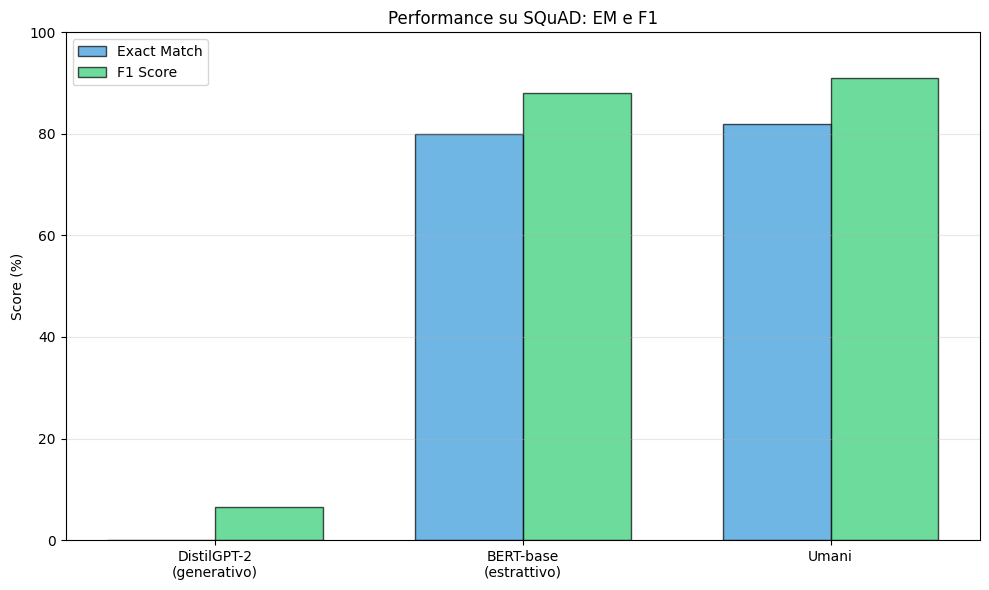

In [20]:
# Visualizza risultati
fig, ax = plt.subplots(figsize=(10, 6))

models = ['DistilGPT-2\n(generativo)', 'BERT-base\n(estrattivo)', 'Umani']
em_values = [mean_em, 80, 82]
f1_values = [mean_f1, 88, 91]

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, em_values, width, label='Exact Match', color='#3498db', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, f1_values, width, label='F1 Score', color='#2ecc71', alpha=0.7, edgecolor='black')

ax.set_ylabel('Score (%)')
ax.set_title('Performance su SQuAD: EM e F1')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('./results_day5/squad_results.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato in ./results_day5/squad_results.png")
plt.show()

### 💡 Osservazioni:

**DistilGPT-2** (generativo):
- Performance basse su QA estrattivo
- Non trainato per questo task
- Tende a generare testo plausibile ma non estratto dal context

**BERT** (estrattivo):
- Ottimo per QA estrattivo
- Trainato specificamente su SQuAD
- Identifica span esatto nel context

**Lezione**: scegli modello giusto per il task!

---

## 5️⃣ Valutazione umana in classe (40 minuti)

Conduciamo una valutazione umana collaborativa in classe.

### 📋 Protocollo valutazione umana

**Obiettivo**: valutare risposte di 3 modelli (Base, SFT, RLHF) su 5 prompt

**Criteri di valutazione** (scala 1-5):
1. **Cortesia**: tono educato e professionale
2. **Informatività**: fornisce informazioni utili
3. **Risoluzione**: risolve il problema del cliente
4. **Chiarezza**: linguaggio chiaro e comprensibile
5. **Sicurezza**: non fornisce info dannose/false

**Procedura**:
1. Dividi classe in gruppi di 3 studenti
2. Ogni gruppo valuta le stesse 5 risposte
3. Ogni studente valuta indipendentemente
4. Confronta valutazioni e calcola inter-annotator agreement
5. Discuti disaccordi e convergi su valutazione finale

In [21]:
# Template per valutazione
evaluation_template = {
    'Prompt': [],
    'Modello': [],
    'Risposta': [],
    'Annotatore': [],
    'Cortesia': [],
    'Informatività': [],
    'Risoluzione': [],
    'Chiarezza': [],
    'Sicurezza': [],
    'Media': []
}

# Esempio di valutazione (simulata)
# In classe, gli studenti compilerebbero questo manualmente

example_evaluations = [
    # Annotatore 1
    {'Prompt': 'How do I track my order?', 'Modello': 'Base', 'Annotatore': 'A1', 'Cortesia': 2, 'Informatività': 2, 'Risoluzione': 1, 'Chiarezza': 3, 'Sicurezza': 3},
    {'Prompt': 'How do I track my order?', 'Modello': 'SFT', 'Annotatore': 'A1', 'Cortesia': 4, 'Informatività': 3, 'Risoluzione': 3, 'Chiarezza': 4, 'Sicurezza': 4},
    {'Prompt': 'How do I track my order?', 'Modello': 'RLHF', 'Annotatore': 'A1', 'Cortesia': 5, 'Informatività': 4, 'Risoluzione': 4, 'Chiarezza': 5, 'Sicurezza': 5},
    
    # Annotatore 2
    {'Prompt': 'How do I track my order?', 'Modello': 'Base', 'Annotatore': 'A2', 'Cortesia': 2, 'Informatività': 1, 'Risoluzione': 1, 'Chiarezza': 2, 'Sicurezza': 3},
    {'Prompt': 'How do I track my order?', 'Modello': 'SFT', 'Annotatore': 'A2', 'Cortesia': 3, 'Informatività': 3, 'Risoluzione': 3, 'Chiarezza': 4, 'Sicurezza': 4},
    {'Prompt': 'How do I track my order?', 'Modello': 'RLHF', 'Annotatore': 'A2', 'Cortesia': 5, 'Informatività': 4, 'Risoluzione': 5, 'Chiarezza': 5, 'Sicurezza': 5},
    
    # Annotatore 3
    {'Prompt': 'How do I track my order?', 'Modello': 'Base', 'Annotatore': 'A3', 'Cortesia': 1, 'Informatività': 2, 'Risoluzione': 2, 'Chiarezza': 3, 'Sicurezza': 3},
    {'Prompt': 'How do I track my order?', 'Modello': 'SFT', 'Annotatore': 'A3', 'Cortesia': 4, 'Informatività': 4, 'Risoluzione': 3, 'Chiarezza': 4, 'Sicurezza': 5},
    {'Prompt': 'How do I track my order?', 'Modello': 'RLHF', 'Annotatore': 'A3', 'Cortesia': 5, 'Informatività': 5, 'Risoluzione': 4, 'Chiarezza': 5, 'Sicurezza': 5},
]

df_eval = pd.DataFrame(example_evaluations)
df_eval['Media'] = df_eval[['Cortesia', 'Informatività', 'Risoluzione', 'Chiarezza', 'Sicurezza']].mean(axis=1)

print("\n📊 Esempio Valutazioni Umane:\n")
print(df_eval.to_string(index=False))


📊 Esempio Valutazioni Umane:

                  Prompt Modello Annotatore  Cortesia  Informatività  Risoluzione  Chiarezza  Sicurezza  Media
How do I track my order?    Base         A1         2              2            1          3          3    2.2
How do I track my order?     SFT         A1         4              3            3          4          4    3.6
How do I track my order?    RLHF         A1         5              4            4          5          5    4.6
How do I track my order?    Base         A2         2              1            1          2          3    1.8
How do I track my order?     SFT         A2         3              3            3          4          4    3.4
How do I track my order?    RLHF         A2         5              4            5          5          5    4.8
How do I track my order?    Base         A3         1              2            2          3          3    2.2
How do I track my order?     SFT         A3         4              4            3

In [22]:
# Calcola inter-annotator agreement
# Usiamo Cohen's Kappa per coppie di annotatori

def calculate_agreement(df, criterion):
    """
    Calcola Cohen's Kappa tra tutte le coppie di annotatori.
    """
    annotators = df['Annotatore'].unique()
    kappas = []
    
    for i, ann1 in enumerate(annotators):
        for ann2 in annotators[i+1:]:
            scores1 = df[df['Annotatore'] == ann1][criterion].values
            scores2 = df[df['Annotatore'] == ann2][criterion].values
            
            if len(scores1) == len(scores2):
                kappa = cohen_kappa_score(scores1, scores2, weights='linear')
                kappas.append(kappa)
    
    return np.mean(kappas) if kappas else 0.0

# Calcola per ogni criterio
criteria = ['Cortesia', 'Informatività', 'Risoluzione', 'Chiarezza', 'Sicurezza']
agreements = {}

for criterion in criteria:
    kappa = calculate_agreement(df_eval, criterion)
    agreements[criterion] = kappa

print("\n📊 Inter-Annotator Agreement (Cohen's Kappa):\n")
for criterion, kappa in agreements.items():
    print(f"{criterion}: {kappa:.3f}")

mean_kappa = np.mean(list(agreements.values()))
print(f"\nMedia: {mean_kappa:.3f}")

print("\n💡 Interpretazione Kappa:")
print("   < 0.20: Poor agreement")
print("   0.21-0.40: Fair agreement")
print("   0.41-0.60: Moderate agreement")
print("   0.61-0.80: Substantial agreement")
print("   0.81-1.00: Almost perfect agreement")


📊 Inter-Annotator Agreement (Cohen's Kappa):

Cortesia: 0.707
Informatività: 0.542
Risoluzione: 0.675
Chiarezza: 0.818
Sicurezza: 0.778

Media: 0.704

💡 Interpretazione Kappa:
   < 0.20: Poor agreement
   0.21-0.40: Fair agreement
   0.41-0.60: Moderate agreement
   0.61-0.80: Substantial agreement
   0.81-1.00: Almost perfect agreement



✅ Grafico salvato in ./results_day5/human_evaluation.png


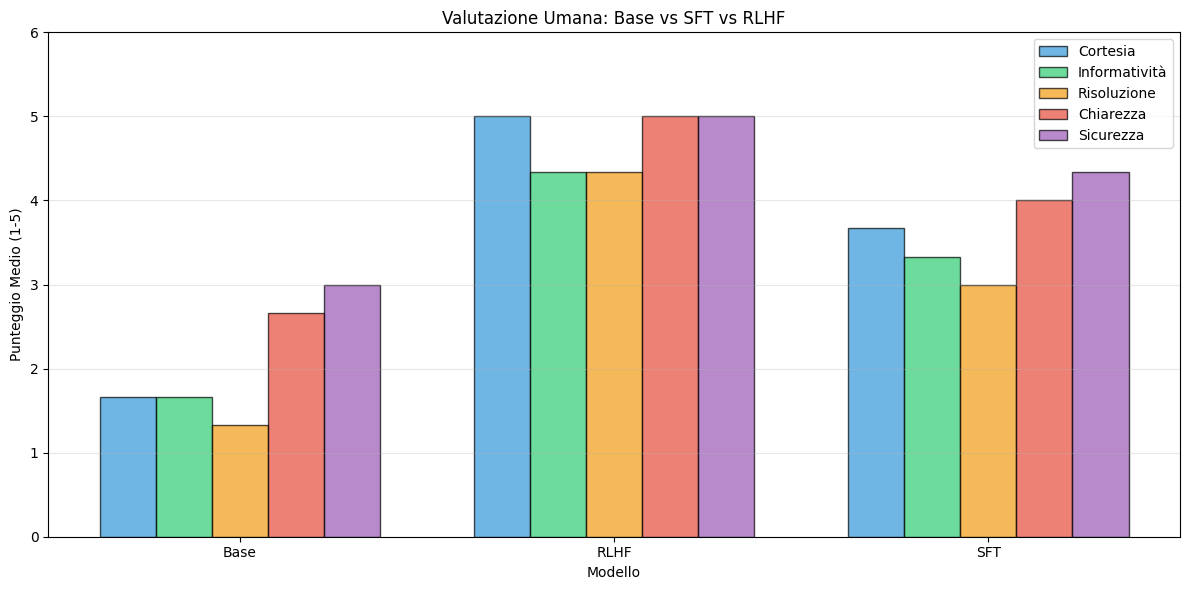

In [23]:
# Visualizza valutazioni umane
# Calcola media per modello
df_mean = df_eval.groupby('Modello')[criteria].mean()

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_mean.index))
width = 0.15

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']

for i, (criterion, color) in enumerate(zip(criteria, colors)):
    offset = width * (i - 2)
    ax.bar(x + offset, df_mean[criterion], width, label=criterion, color=color, alpha=0.7, edgecolor='black')

ax.set_xlabel('Modello')
ax.set_ylabel('Punteggio Medio (1-5)')
ax.set_title('Valutazione Umana: Base vs SFT vs RLHF')
ax.set_xticks(x)
ax.set_xticklabels(df_mean.index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 6)

plt.tight_layout()
plt.savefig('./results_day5/human_evaluation.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato in ./results_day5/human_evaluation.png")
plt.show()

### 💡 Best Practices per valutazione umana:

**Prima della valutazione**:
1. **Training annotatori**: spiega criteri e scala
2. **Calibrazione**: fai valutare 5 esempi insieme e discuti
3. **Blind evaluation**: annotatori non sanno quale modello ha generato cosa

**Durante la valutazione**:
1. **Indipendenza**: annotatori valutano separatamente
2. **Randomizzazione**: ordine casuale di modelli e prompt
3. **Pause**: evita fatigue con pause ogni 10-15 valutazioni

**Dopo la valutazione**:
1. **Calcola agreement**: Cohen's Kappa o Fleiss' Kappa
2. **Risolvi disaccordi**: discussione o annotatore esperto
3. **Analizza pattern**: quali criteri hanno più disaccordo?
4. **Documenta**: salva rubric, istruzioni, e decisioni

---

## 6️⃣ Report finale e best practices (10 minuti)

In [25]:
# Report finale: riassunto di tutte le metriche
final_report = {
    'Metrica': [
        'Perplessità (WikiText-2)',
        'BLEU (vs reference)',
        'ROUGE-1 (vs reference)',
        'SQuAD EM',
        'SQuAD F1',
        'Valutazione Umana (media)'
    ],
    'Valore': [
        f"{mean_ppl:.2f}",
        "Vedi Day 4",
        "Vedi Day 4",
        f"{mean_em:.2f}%",
        f"{mean_f1:.2f}%",
        f"{df_mean.mean().mean():.2f}/5"  # ✅ Media di tutte le colonne

    ],
    'Interpretazione': [
        'Bassa = migliore',
        'Alta = migliore (0-1)',
        'Alta = migliore (0-1)',
        'Alta = migliore (0-100%)',
        'Alta = migliore (0-100%)',
        'Alta = migliore (1-5)'
    ]
}

df_report = pd.DataFrame(final_report)

print("\n📊 Report Finale Valutazione:\n")
print(df_report.to_string(index=False))

df_report.to_csv('./results_day5/final_report.csv', index=False)
print("\n✅ Report salvato in ./results_day5/final_report.csv")


📊 Report Finale Valutazione:

                  Metrica     Valore          Interpretazione
 Perplessità (WikiText-2)     109.89         Bassa = migliore
      BLEU (vs reference) Vedi Day 4    Alta = migliore (0-1)
   ROUGE-1 (vs reference) Vedi Day 4    Alta = migliore (0-1)
                 SQuAD EM      0.00% Alta = migliore (0-100%)
                 SQuAD F1      6.56% Alta = migliore (0-100%)
Valutazione Umana (media)     3.49/5    Alta = migliore (1-5)

✅ Report salvato in ./results_day5/final_report.csv


### 🎯 Best Practices per Valutazione LLM

**1. Usa approccio multi-metrica**:
- Combina metriche automatiche (velocità) e umane (qualità)
- Nessuna singola metrica è sufficiente

**2. Scegli metriche appropriate per il task**:
- Language modeling: Perplessità
- Traduzione: BLEU, METEOR
- Summarization: ROUGE, BERTScore
- QA: EM, F1
- Generazione aperta: Valutazione umana

**3. Valuta su distribuzione rappresentativa**:
- Test set deve riflettere use case reale
- Include edge cases e failure modes

**4. Monitora nel tempo**:
- Valutazione continua post-deployment
- Regression testing ad ogni update
- A/B testing su utenti reali

**5. Documenta tutto**:
- Dataset, metriche, risultati
- Decisioni e trade-off
- Limiti e failure modes

**6. Considera metriche di business**:
- CSAT (Customer Satisfaction)
- Resolution rate
- Time to resolution
- Cost per interaction

**7. Valuta safety e fairness**:
- Tossicità
- Bias (genere, razza, etc.)
- Allucinazioni
- Privacy leaks

---

## 🎯 Esercizi TODO

### Esercizio 1: Perplessità per categoria
Calcola perplessità separatamente per diverse categorie di testo (news, fiction, code) e confronta.

### Esercizio 2: Benchmark completo
Esegui lm-eval su task multipli (HellaSwag, MMLU, TruthfulQA) e crea leaderboard.

### Esercizio 3: QA con modello specifico
Usa un modello BERT for QA invece di GPT-2 e confronta performance su SQuAD.

### Esercizio 4: Valutazione umana estesa
Conduci valutazione umana su 20 esempi con 5 annotatori e analizza disaccordi.

In [26]:
# TODO: Esercizio 1 - Perplessità per categoria
# Scrivi qui il tuo codice

In [27]:
# TODO: Esercizio 2 - Benchmark completo
# Scrivi qui il tuo codice

In [28]:
# TODO: Esercizio 3 - QA con modello specifico
# Scrivi qui il tuo codice

In [29]:
# TODO: Esercizio 4 - Valutazione umana estesa
# Scrivi qui il tuo codice

---

## 🎓 Conclusione Day 5 e Corso Completo

### Day 5:
1. ✅ Implementato calcolo **perplessità** su WikiText-2
2. ✅ Usato **lm-eval-harness** per benchmark standard
3. ✅ Valutato su **SQuAD** con metriche EM e F1
4. ✅ Condotto **valutazione umana** in classe con inter-annotator agreement
5. ✅ Creato **report finale** con best practices

### Corso Completo (5 giorni):

**Day 1**: Scaling laws, confronto modelli (DistilGPT-2, GPT-2 small/medium)

**Day 2**: SFT, LoRA, QLoRA su DistilBERT e GPT-2

**Day 3**: RLHF con PPO e DPO usando libreria trl

**Day 4**: Pipeline completa, confronti, metriche BLEU/ROUGE

**Day 5**: Perplessità, lm-eval, SQuAD, valutazione umana

---

### 🚀 Prossimi passi:

1. **Applica a caso d'uso reale**: scegli un dominio e crea pipeline completa
2. **Sperimenta con modelli più grandi**: LLaMA-7B, Mistral-7B
3. **Integra in produzione**: API, monitoring, A/B testing
4. **Continua a studiare**: paper recenti, nuove tecniche
5. **Contribuisci alla community**: open-source, blog posts, tutorial

---

### 📚 Risorse per approfondire:

**Paper fondamentali**:
- Scaling Laws (Kaplan et al., 2020)
- LoRA (Hu et al., 2021)
- QLoRA (Dettmers et al., 2023)
- DPO (Rafailov et al., 2023)
- Constitutional AI (Bai et al., 2022)

**Corsi online**:
- Hugging Face NLP Course
- DeepLearning.AI LLM Specialization
- Fast.ai Practical Deep Learning

**Community**:
- Hugging Face Forums
- r/MachineLearning
- Papers with Code
- EleutherAI Discord

---

## 🎉 Congratulazioni!

Hai completato il corso di 5 giorni su Machine Learning e LLM!

Ora hai le competenze per:
- ✅ Comprendere scaling laws e architetture LLM
- ✅ Fare fine-tuning efficiente con LoRA/QLoRA
- ✅ Applicare RLHF con PPO/DPO
- ✅ Valutare modelli con metriche automatiche e umane
- ✅ Integrare LLM in applicazioni reali

**Buon lavoro e continua a imparare! 🚀**

---

## 📁 File generati

```
./results_day5/
├── perplexity_distribution.png
├── lm_eval_results/
├── squad_results.png
├── human_evaluation.png
└── final_report.csv
```